In [1]:
import sqlite3
import csv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
def read_sales_csv(filename):
    sales = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            date = datetime.strptime(row['date'], '%m/%d/%y')
            sales.append({'date': date,
                     'days_ago': (datetime.now() - date).days,
                     'account_number': row['account_number'],
                     'price': int(row['price'])})
    return sales

conn = sqlite3.connect('file:NW_Central_OKC_w_bldg_details.db?mode=ro', uri=True)
c = conn.cursor()

sales = read_sales_csv('sales_list_2019.csv')
#sales = sales + read_sales_csv('sales_list_2018.csv')
#sales = sales + read_sales_csv('sales_list_2017.csv')

Now let's load the data into DataFrames. We have two tables we're using, one for properties/parcels and one for buildings. So what we'll do is pull out some data about the buildings, sum it up (as some properties have more than 1 building), and add it to the property DF.

In [3]:
combined_df = pd.read_sql_query("SELECT * FROM realproperty INNER JOIN buildings ON realproperty.id = buildings.local_property_id;", conn)
rp_df = pd.read_sql_query("SELECT * FROM realproperty WHERE property_type = 'Residential'", conn)
rp_df = rp_df.set_index('account_number')

# Get data about the buildings for each parcel. We'll sum up the data for now
# (in cases where there's >1 building on the property)
rp_df['sqft_sum'] = combined_df.groupby(['account_number'])['sq_ft'].sum()
rp_df['bed_sum'] = combined_df.replace(-1,0).groupby(['account_number'])['bedrooms'].sum()
rp_df['bath_sum'] = combined_df.replace(-1,0).groupby(['account_number'])['full_bathrooms'].sum() +\
    (combined_df.replace(-1,0).groupby(['account_number'])['three_quarters_bathrooms'].sum() * 0.75) +\
    (combined_df.replace(-1,0).groupby(['account_number'])['half_bathrooms'].sum() * 0.5)
rp_df['room_sum'] = combined_df.replace(-1,0).groupby(['account_number'])['total_rooms'].sum()
rp_df['main_bldg_sqft'] = combined_df.groupby(['account_number'])['sq_ft'].max()
rp_df['year_built'] = combined_df[combined_df.year_built != -1].groupby(['account_number'])['year_built'].mean()
rp_df['bldg_age'] = pd.datetime.now().year - rp_df['year_built']

display(rp_df)

,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,...,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age
account_number,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,...,001,001,EDGEMERE TERRACE 001 001,1824.0,3.0,2.00,7.0,1824.0,1951.0,68.0
R049810050,3,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,...,001,002,EDGEMERE TERRACE 001 002,2677.0,3.0,2.50,6.0,2677.0,1951.0,68.0
R049480080,6,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,...,001,004,CROWN HEIGHTS ADD 001 004,1961.0,2.0,2.00,9.0,1961.0,1939.0,80.0
R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,...,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0
R049640010,8,131005,Residential,504 NW 50TH ST,,OKLAHOMA CITY,DICKSON JERRY ROBERT,,504 NW 50TH ST,,...,001,000,DOUGLAS PLACE ADD 001 000 LOTS 3 & 4,1386.0,3.0,1.50,6.0,1386.0,1951.0,68.0
R049640015,9,131006,Residential,508 NW 50TH ST,,OKLAHOMA CITY,GARRETT & COMPANY LLC,,9701 BROADWAY EXT,,...,001,000,DOUGLAS PLACE ADD 001 000 LOTS 5 & 6,1092.0,2.0,1.00,4.0,1092.0,1950.0,69.0
R049810100,10,130119,Residential,418 NW 43RD ST,,OKLAHOMA CITY,BRADEN THOMAS GARY & BEVERLY JOAN,REVOCABLE LIVING TRUST,418 NW 43RD ST,,...,001,004,EDGEMERE TERRACE 001 004,2047.0,2.0,2.00,7.0,2047.0,1951.0,68.0
R049640020,12,131007,Residential,512 NW 50TH ST,,OKLAHOMA CITY,HALPIN JEFFREY J,,512 NW 50TH ST,,...,001,000,DOUGLAS PLACE ADD 001 000 LOTS 7 & 8,1038.0,2.0,1.00,4.0,1038.0,1950.0,69.0
R049480100,13,130505,Residential,1005 NW 42ND ST,,OKLAHOMA CITY,DK INC,,C/O KENNETH L SPEARS,PO BOX 687,...,001,005,CROWN HEIGHTS ADD 001 005,1660.0,2.0,2.00,8.0,1660.0,1947.0,72.0


Now let's add more features for the main building. To do this we'll create a new DataFrame containing the features of the largest building on each property. While most single-family properties only have one building, we do need to consider that some will have multiple.

In [4]:
# we want 26584 not 26631
idx = combined_df.groupby(['account_number'])['sq_ft'].transform(max) == combined_df['sq_ft']
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)
combined_df2 = combined_df[idx]


# now that we have the ones with largest sq ft on the parcel, let's weed out duplicates (where there are
# multiple bldgs with identical sq ft)
idx = combined_df2.groupby(['account_number'])['bldg_id'].transform(max) == combined_df2['bldg_id']
combined_df2 = combined_df2[idx]
combined_df2 = combined_df2.set_index(['account_number'])
combined_df2

,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,id,local_property_id,bldg_id,vacant_or_improved,bldg_description,year_built,sq_ft,number_stories,remodel_year,building_name,alt_land_use_desc,quality_description,frame_description,foundation_description,exterior,roof_type,roof_cover,avg_floor_height,percent_sprinkled,total_rooms,bedrooms,full_bathrooms,three_quarters_bathrooms,half_bathrooms,hvac_type,physical_condition,number_res_units,number_comm_units
account_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,13068.0,None,None,52721,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,001,EDGEMERE TERRACE 001 001,1,1,1,Improved,Ranch 1 Story,1951,1824,1.0,2014,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Hip,Composition Shingle,8,0,7,3,2,0,0,Central Air to Air,Average,1,0
R049480020,2,130501,Commercial,4300 N WESTERN AVE,PARKING FOR BARREL AND DRUM ROOM,OKLAHOMA CITY,VHG PROPERTY INTERESTS LLC,,PO BOX 18877,,"OKLAHOMA CITY, OK 73154",2663,,TXD 200,Oklahoma City #89,10454.4,None,None,124585,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,000,CROWN HEIGHTS ADD 001 000 S89.5FT LOTS 1 & 2,2,2,1,Improved,Parking Lot,2005,0,1.0,-1,PARKING FOR BARREL AND DRUM ROOM,Commercial Improvement,None,None,,,,,8,0,-1,-1,0,0,0,None,Poor,0,0
R049810050,3,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,002,EDGEMERE TERRACE 001 002,3,3,1,Improved,Split Level,1951,2677,1.0,2010,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Hip,Composition Shingle,8,0,6,3,2,0,1,Central Air to Air,Average,1,0
R049480040,4,130502,Commercial,4308 N WESTERN AVE,BARREL,OKLAHOMA CITY,VHG PROPERTY INTERESTS LLC,,PO BOX 18877,,"OKLAHOMA CITY, OK 73154-0877",2663,,TXD 200,Oklahoma City #89,13068.0,None,None,79000,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,000,CROWN HEIGHTS ADD 001 000 N50FT LOTS 1 & 2 & A...,4,4,1,Improved,Restaurant,1935,4738,1.0,2005,BARREL,Commercial Improvement,Fair,Masonry,,,Flat,,12,0,-1,-1,0,0,0,Complete HVAC,Good,0,1
R056050500,5,131543,Commercial,1112 NW 50TH ST,QUEEN BEE/ PRAIRIE ARTS/ BOARD UP,OKLAHOMA CITY,FOREST SIDING SUPPLY LLC,,1117 NW 50TH ST,,"OKLAHOMA CITY, OK 73118",2665,,TXD 200,Oklahoma City #89,15681.6,None,None,78000,Sect 17-T12N-R3W Qtr NE,ISLE VIEW SUB ADD,001,000,ISLE VIEW SUB ADD 001 000 LOTS 7 THRU 10,5,5,1,Improved,Ranch 1 Story,1925,1708,1.0,2000,QUEEN BEE/ PRAIRIE ARTS/ BOARD UP,Commercial Improvement,Average,,Slab,Frame Masonry Veneer,Gable,Composition Shingle,8,0,0,0,0,0,0,Central Air to Air,Average,1,0
R049480080,6,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,"OKLAHOMA CITY, OK 73103-3902",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,004,CROWN HEIGHTS ADD 001 004,7,6,1,Improved,Duplex One Story,1939,1961,1.0,1977,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Hip,Composition Shingle,8,0,9,2,2,0,0,Central Air to Air,Average,2,0
R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,8,7,1,Improved,Ranch 1 Story,1951,1352,1.0,1997,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Gable,Composition Shingle,8,0,6,3,1,0,1,Central Air to 

Now we have the features for the largest building on each parcel. Let's add some of these to combined_df (like we did above).

In [5]:
print(len(rp_df))
print(len(combined_df2))
#print(combined_df2.groupby(['account_number'])['bldg_description'])
rp_df['main_bldg_description'] = combined_df2['bldg_description']
rp_df['main_bldg_hvac'] = combined_df2['hvac_type']
rp_df['main_bldg_quality'] = combined_df2['quality_description']
# Floor height is not worth using as it is listed as 8 on the vast majority of residential properties
rp_df['main_bldg_exterior'] = combined_df2['exterior']
rp_df['main_bldg_roof'] = combined_df2['roof_type']
rp_df['main_bldg_year'] = combined_df2['year_built']
rp_df['main_bldg_effective_year'] = combined_df2[['year_built', 'remodel_year']].max(axis=1) # remodel year, else built year
rp_df

21978
26584


,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age,main_bldg_description,main_bldg_hvac,main_bldg_quality,main_bldg_exterior,main_bldg_roof,main_bldg_year,main_bldg_effective_year
account_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,13068.0,None,None,52721,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,001,EDGEMERE TERRACE 001 001,1824.0,3.0,2.00,7.0,1824.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2014.0
R049810050,3,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,002,EDGEMERE TERRACE 001 002,2677.0,3.0,2.50,6.0,2677.0,1951.0,68.0,Split Level,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2010.0
R049480080,6,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,"OKLAHOMA CITY, OK 73103-3902",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,004,CROWN HEIGHTS ADD 001 004,1961.0,2.0,2.00,9.0,1961.0,1939.0,80.0,Duplex One Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1939.0,1977.0
R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0
R049640010,8,131005,Residential,504 NW 50TH ST,,OKLAHOMA CITY,DICKSON JERRY ROBERT,,504 NW 50TH ST,,"OKLAHOMA CITY, OK 73118-6204",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 3 & 4,1386.0,3.0,1.50,6.0,1386.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2001.0
R049640015,9,131006,Residential,508 NW 50TH ST,,OKLAHOMA CITY,GARRETT & COMPANY LLC,,9701 BROADWAY EXT,,"OKLAHOMA CITY, OK 73114-6316",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 5 & 6,1092.0,2.0,1.00,4.0,1092.0,1950.0,69.0,Ranch 1 Story,Floor Wall Furnace,Fair,Frame Masonry Veneer,Hip,1950.0,1950.0
R049810100,10,130119,Residential,418 NW 43RD ST,,OKLAHOMA CITY,BRADEN THOMAS GARY & BEVERLY JOAN,REVOCABLE LIVING TRUST,418 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,004,EDGEMERE TERRACE 001 004,2047.0,2.0,2.00,7.0,2047.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,1992.0
R049640020,12,131007,Residential,512 NW 50TH ST,,OKLAHOMA CITY,HALPIN JEFFREY J,,512 NW 50TH ST,,"OKLAHOMA CITY, OK 73118-6204",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 7 & 8,1038.0,2.0,1.00,4.0,1038.0,1950.0,69.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1950.0,1980.0
R049480100,13,130505,Residential,1005 NW 42ND ST,,OKLAHOMA CITY,DK INC,,C/O KENNETH L SPEARS,PO BOX 687,"OKLAHOMA CITY, OK 73101",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,005,CROWN HEIGHTS ADD 001 005,1660.0,2.0,2.00,8.0,1660.0,1947.0,72.0,Duple

In [6]:
# This filters for subdivision based on number of properties in that sub. Let's change it
# later to filter for number of transactions.
sublist = (rp_df[['subdivision']]
            .assign(count = 0)
            .groupby("subdivision")
            .count())
sublist = sublist.where(sublist['count'] >= 100).dropna()
sublist_names = sublist.index.values
display(sublist_names)

rp_df['subdivision'] = rp_df.apply(lambda x: "Other" if x['subdivision'] not in sublist_names else x['subdivision'], axis=1)

array(['AURORA ADDITION', 'BAUMANS ADDITION', 'BELL VERN ADDITION',
       'CARLE & COLCORD ADDITION', 'CASHION PLACE ADDITION',
       'CASHION PLACE AMD', 'CENTRAL PARK ADDITION',
       'CLASSENS CREAM RIDGE', 'COLLEGE ADDITION', 'CRESTWOOD ADDITION',
       'CROWN HEIGHTS ADD', 'DARRALLS SECOND ADD', 'DENNISTON PARK ADD',
       'DOUGLAS PLACE ADD', 'EDGEMERE PARK ADD', 'EDGEMERE TERRACE',
       'EPWORTH VIEW ADD', 'GARDEN ADDITION', 'GATEWOOD ADDITION',
       'GRAND VIEW ADDITION', 'GUERNSEY PARK PLACE',
       'HEMINGWAY CONDOMINIUMS', 'INGLESIDE TO OKLA CITY',
       'JEFFERSON PARK ADD', 'LAS VEGAS ADDITION',
       'LINWOOD PLACE AMENDED', 'LINWOOD PLACE SECOND',
       'LYONS WILL ROGERS PK', 'MAYFAIR HEIGHTS BLKS 1 THRU 29',
       'MILAM PLACE ADDITION', 'MILITARY PARK ADD', 'MILLERS BOULEVARD',
       'MORRIS WILL ROGER PARK', 'NEAS ADDITION', 'PACKINGHOUSE PARK',
       'PARKER & COLCORD ADD', 'PUTNAM HEIGHTS 2ND', 'PUTNAM HEIGHTS ADD',
       'RAVENSWOOD ADDITION', 'RI

In [7]:
sales_df = pd.DataFrame(sales)
display(sales_df)

,account_number,date,days_ago,price
0,R188308300,2019-10-10,35,216000
1,R212841600,2019-10-10,35,227000
2,R109711175,2019-10-09,36,75000
3,R109731255,2019-10-09,36,120000
4,R151661260,2019-10-09,36,49000
5,R056651065,2019-10-09,36,65000
6,R122251185,2019-10-09,36,86000
7,R130762112,2019-10-08,37,40500
8,R203061190,2019-10-08,37,825000
9,R034354750,2019-10-08,37,140000


In [8]:
merged_df = pd.merge(rp_df, sales_df, on='account_number', how='inner')
display(merged_df)

,account_number,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age,main_bldg_description,main_bldg_hvac,main_bldg_quality,main_bldg_exterior,main_bldg_roof,main_bldg_year,main_bldg_effective_year,date,days_ago,price
0,R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0,2019-07-02,135,108000
1,R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0,2019-05-10,188,108000
2,R049810175,27,130122,Residential,436 NW 43RD ST,,OKLAHOMA CITY,BELFLOWER ADAM P & ALEXANDRA,,436 NW 43RD ST,,"OKLAHOMA CITY , OK 73118",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,007,EDGEMERE TERRACE 001 007,2018.0,3.0,2.00,7.0,2018.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2007.0,2019-04-05,223,305000
3,R049640070,50,131015,Residential,5000 N LEE AVE,,OKLAHOMA CITY,KUMBALEK MICHAEL MAX,,5000 N LEE AVE,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 23 & 24,1429.0,2.0,1.75,6.0,1429.0,1950.0,69.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1950.0,1970.0,2019-05-15,183,157000
4,R049810375,66,130130,Residential,427 NW 43RD ST,,OKLAHOMA CITY,STALL JOSPEH E,LAWMASTER JENNIFER L,427 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,005,EDGEMERE TERRACE 002 005,2155.0,3.0,2.00,4.0,2155.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2007.0,2019-09-06,69,335000
5,R049810425,76,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,SCHEER BRADY D,SCHEER MACKENZIE K,415 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,007,EDGEMERE TERRACE 002 007,2097.0,3.0,2.50,7.0,2097.0,1952.0,67.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1952.0,2010.0,2019-06-05,162,343500
6,R049810425,76,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,SCHEER BRADY D,SCHEER MACKENZIE K,415 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,007,EDGEMERE TERRACE 002 007,2097.0,3.0,2.50,7.0,2097.0,1952.0,67.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1952.0,2010.0,2019-05-06,192,343500
7,R049820200,94,130383,Residential,305 NW 42ND ST,,OKLAHOMA CITY,SCAPERLANDA MICHAEL A & MARIA RUIZ,,3816 WAVERLY CT,,"NORMAN, OK 73072",2662,,TXD 200,Oklahoma City #89,17859.6,None,None,85603,Sect 16-T12N-R3W Qtr SE,Other,001,002,EDGEMERE HEIGHTS ADD 001 002,2541.0,4.0,2.00,8.0,2541.0,1952.0,67.0,Ranch 1 Story,Central Air to Air,Average,Frame Masonry Veneer,Hip,1952.0,2019.0,2019-05-29,169,415000
8,R049810550,101,130137,Residential,412 NW 44TH ST,,OKLAHOMA CITY,PENNINGTON PARKER B,,412 NW 44TH ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,7405.2,None,None,36720,Sect 16-T

In [9]:
included_fields = ['land_size', 'land_value', 'subdivision', 'bldg_age', 'year_built', 'sqft_sum', 'bed_sum', 'bath_sum', 'price', 'days_ago', 'main_bldg_hvac', 'main_bldg_description', 'main_bldg_exterior', 'main_bldg_quality', 'main_bldg_roof', 'main_bldg_year', 'main_bldg_effective_year', 'room_sum']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### One Hot Encoding

We use one hot encoding for the subdivision feature. As a result, we create a feature for each individual neighborhood and other categorical features.

In [11]:
from sklearn.linear_model import LinearRegression
new_df = (merged_df[included_fields][merged_df.price != 0]
          .dropna()
          .reset_index()
          .drop(columns=['index']))
#new_df = new_df[new_df.price != 0]

ohenc = preprocessing.OneHotEncoder()

In [12]:
new_df.describe()

,land_size,land_value,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_year,main_bldg_effective_year,room_sum
count,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000
mean,7626.407785,32095.328720,82.260525,1936.739475,1552.497405,2.820069,1.625865,182051.182526,169.446367,1936.683391,1988.553633,6.058824
std,2760.260627,22096.899762,19.882818,19.882818,633.204873,0.903372,0.774771,142940.023431,76.580872,19.898229,33.336974,1.835673
min,0.000000,917.000000,0.000000,1903.000000,240.000000,1.000000,1.000000,500.000000,38.000000,1903.000000,1905.000000,2.000000
25%,6969.600000,19600.000000,72.000000,1924.000000,1117.000000,2.000000,1.000000,91375.000000,105.000000,1923.750000,1960.000000,5.000000
50%,6969.600000,25364.000000,84.000000,1935.000000,1408.500000,3.000000,1.500000,143500.000000,167.000000,1935.000000,2005.000000,6.000000
75%,8276.400000,36285.750000,95.000000,1947.000000,1825.250000,3.000000,2.000000,226000.000000,234.000000,1947.000000,2017.000000,7.000000
max,50094.000000,248780.000000,116.000000,2019.000000,5658.000000,10.000000,7.500000,990000.000000,317.000000,2019.000000,2019.000000,20.000000


In [13]:
def return_encoded(df, feature_name, feature_prefix):
    ohenc.fit([[x] for x in df[feature_name]])
    encoded = ohenc.transform([[x] for x in df[feature_name]]).toarray()
    return pd.DataFrame(encoded, columns=[feature_prefix+"-" + ohenc.categories_[0][i] for i in range(encoded.shape[1])])

In [14]:
encoded_df_names = [
    ['subdivision','Sub'],
    ['main_bldg_hvac', 'HVAC'],
    ['main_bldg_description', 'Descr'],
    ['main_bldg_exterior', 'Exterior'],
    ['main_bldg_roof', 'Roof']
]

encoded_dfs = []
encoders = {}
for (col_name, prefix) in encoded_df_names:
    cur_df = return_encoded(new_df, col_name, prefix)
    encoded_dfs.append(cur_df)

In [15]:
unused_col_names = ['main_bldg_quality']

new_df = new_df.drop(columns=([x[0] for x in encoded_df_names]+[x for x in unused_col_names]))
new_df = pd.concat(([new_df] + [x for x in encoded_dfs]), axis=1)
display(new_df)

,land_size,land_value,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_year,main_bldg_effective_year,room_sum,Sub-AURORA ADDITION,Sub-BAUMANS ADDITION,Sub-BELL VERN ADDITION,Sub-CARLE & COLCORD ADDITION,Sub-CASHION PLACE ADDITION,Sub-CASHION PLACE AMD,Sub-CENTRAL PARK ADDITION,Sub-CLASSENS CREAM RIDGE,Sub-COLLEGE ADDITION,Sub-CRESTWOOD ADDITION,Sub-CROWN HEIGHTS ADD,Sub-DARRALLS SECOND ADD,Sub-DENNISTON PARK ADD,Sub-DOUGLAS PLACE ADD,Sub-EDGEMERE PARK ADD,Sub-EDGEMERE TERRACE,Sub-EPWORTH VIEW ADD,Sub-GARDEN ADDITION,...,Descr-Duplex One half Story,Descr-Duplex Two Story,Descr-Permit Value,Descr-Ranch 1 Story,Descr-Salvage,Descr-Split Level,Descr-Townhouse Multiple Story,Descr-Triplex Multiple Story,Exterior-,Exterior-Frame Aluminum,Exterior-Frame Asbestos,Exterior-Frame Brick Veneer,Exterior-Frame Hardboard,Exterior-Frame Masonry Veneer,Exterior-Frame Permastone,Exterior-Frame Siding,Exterior-Frame Stucco,Exterior-Frame Vinyl,Exterior-High Profile Dome,Exterior-Masonry Concrete Block,Exterior-Masonry Stone,Exterior-Minimal,Exterior-None,Roof-Flat,Roof-Gable,Roof-Gable/Hip,Roof-Gambrel,Roof-Hip,Roof-Hip/Gable,Roof-Mansard
0,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,135,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,188,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,9147.6,45900,68.0,1951.0,2018.0,3.0,2.00,305000,223,1951.0,2007.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6969.6,37100,69.0,1950.0,1429.0,2.0,1.75,157000,183,1950.0,1970.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,8276.4,42840,68.0,1951.0,2155.0,3.0,2.00,335000,69,1951.0,2007.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,162,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,192,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,17859.6,85603,67.0,1952.0,2541.0,4.0,2.00,415000,169,1952.0,2019.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,7405.2,36720,68.0,1951.0,1416.0,3.0,1.75,182500,245,1951.0,2015.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,8276.4,80559,83.0,1936.0,2316.0,4.0,1.75,555000,154,1936.0,2017.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Correlation

Let's look at the correlation of the various featues. We see that some features like square footage, # of beds/baths, and land size have a positive correlation.

Some of the more desirable subdivisions have a positive correlation too, while many other neighborhoods have a negative correlation with the sale price (relative to other sales in our data set). Do note that this is correlation for the price of the property - not price relative to building or land size.

Year built/building age is close enough to zero to have no correlation. And as we might expect, days_ago has a negative correlation, indicating that prices have generally been increasing over time.

In [16]:
pd.set_option('max_rows',100)
dfcorr = new_df.corr()
new_df

,land_size,land_value,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_year,main_bldg_effective_year,room_sum,Sub-AURORA ADDITION,Sub-BAUMANS ADDITION,Sub-BELL VERN ADDITION,Sub-CARLE & COLCORD ADDITION,Sub-CASHION PLACE ADDITION,Sub-CASHION PLACE AMD,Sub-CENTRAL PARK ADDITION,Sub-CLASSENS CREAM RIDGE,Sub-COLLEGE ADDITION,Sub-CRESTWOOD ADDITION,Sub-CROWN HEIGHTS ADD,Sub-DARRALLS SECOND ADD,Sub-DENNISTON PARK ADD,Sub-DOUGLAS PLACE ADD,Sub-EDGEMERE PARK ADD,Sub-EDGEMERE TERRACE,Sub-EPWORTH VIEW ADD,Sub-GARDEN ADDITION,...,Descr-Duplex One half Story,Descr-Duplex Two Story,Descr-Permit Value,Descr-Ranch 1 Story,Descr-Salvage,Descr-Split Level,Descr-Townhouse Multiple Story,Descr-Triplex Multiple Story,Exterior-,Exterior-Frame Aluminum,Exterior-Frame Asbestos,Exterior-Frame Brick Veneer,Exterior-Frame Hardboard,Exterior-Frame Masonry Veneer,Exterior-Frame Permastone,Exterior-Frame Siding,Exterior-Frame Stucco,Exterior-Frame Vinyl,Exterior-High Profile Dome,Exterior-Masonry Concrete Block,Exterior-Masonry Stone,Exterior-Minimal,Exterior-None,Roof-Flat,Roof-Gable,Roof-Gable/Hip,Roof-Gambrel,Roof-Hip,Roof-Hip/Gable,Roof-Mansard
0,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,135,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,188,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,9147.6,45900,68.0,1951.0,2018.0,3.0,2.00,305000,223,1951.0,2007.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6969.6,37100,69.0,1950.0,1429.0,2.0,1.75,157000,183,1950.0,1970.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,8276.4,42840,68.0,1951.0,2155.0,3.0,2.00,335000,69,1951.0,2007.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,162,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,192,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,17859.6,85603,67.0,1952.0,2541.0,4.0,2.00,415000,169,1952.0,2019.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,7405.2,36720,68.0,1951.0,1416.0,3.0,1.75,182500,245,1951.0,2015.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,8276.4,80559,83.0,1936.0,2316.0,4.0,1.75,555000,154,1936.0,2017.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
pd.set_option('max_rows',200)

display(dfcorr['price'].sort_values())

Descr-Ranch 1 Story                  -0.345224
HVAC-Floor Wall Furnace              -0.325195
Roof-Gable                           -0.150675
Exterior-Frame Vinyl                 -0.146219
Exterior-Frame Asbestos              -0.140205
Sub-NEAS ADDITION                    -0.088394
Sub-BAUMANS ADDITION                 -0.084138
Exterior-Frame Hardboard             -0.082175
Sub-WEST LAWN GARDEN ADD             -0.082135
Sub-LYONS WILL ROGERS PK             -0.079698
Sub-Other                            -0.075604
Sub-SHARTEL BOULEVARD                -0.071500
Descr-Condo <= 3 Stories             -0.070712
Sub-WEST POINT AMD E2                -0.067853
Sub-RAVENSWOOD ADDITION              -0.065427
Sub-CARLE & COLCORD ADDITION         -0.062207
Sub-PARKER & COLCORD ADD             -0.059808
Descr-Duplex One Story               -0.059497
Sub-HEMINGWAY CONDOMINIUMS           -0.058515
Exterior-Minimal                     -0.057605
Sub-INGLESIDE TO OKLA CITY           -0.056546
Sub-AURORA AD

In [18]:
new_df = new_df.drop('bldg_age',axis=1)

### Creating a linear regression model

Let's create our linear regression model.

In [19]:
X = new_df.drop('price',axis=1)
y = new_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
linreg = LinearRegression().fit(X_train, y_train)

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

def model_stats(model, Xte, yte, Xtr, ytr, yp):

    print("R^2 for Test Set: " + str(model.score(Xte, yte)))
    print("R^2 for Training Set: " + str(model.score(Xtr,ytr)))
    print("RMS error for Test Set: " + str(np.sqrt(mean_squared_error(yte, yp))))

    print("y_test min: " + str(y_test.min()))
    print("y_test max: " + str(y_test.max()))
    print("y_test mean: " + str(y_test.mean()))
    print("y_predict min: " + str(yp.min()))
    print("y_predict max: " + str(yp.max()))
    print("y_predict mean: " + str(y_predict.mean()))

And if we look at the predicted values, some turn out to be negative. Uh oh.

In [21]:
'''
import numpy as np
ch_oh = ohenc.transform([["EDGEMERE TERRACE"]]).toarray()
ch_args = [10000, 40000, 1990, 3000, 4, 3, 10] + ch_oh.tolist()[0]
ch_args = [6400, 34790, 1500, 1990, 4, 3, 10] + ch_oh.tolist()[0]
#ch_args = ch_oh.tolist()
linreg.predict([ch_args])
'''

y_predict = linreg.predict(X_test)
model_stats(linreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7897173502089012
R^2 for Training Set: 0.836923023053149
RMS error for Test Set: 70496.49638401298
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -57072.42171968508
y_predict max: 882724.637292183
y_predict mean: 184141.39229643904


In [22]:
def plot_test_predict(Xt,yp,yt):
    xy_test_df = pd.concat([Xt.reset_index(), pd.Series(yp), yt.reset_index()],axis=1)

    plt.ylim(xy_test_df[0].min() - 20000, xy_test_df[0].max() + 20000)
    plt.xlim(xy_test_df['price'].min() - 20000, xy_test_df['price'].max() + 20000)

    #estimated_prices_df
    plt.plot(xy_test_df['price'], xy_test_df[0], 'ro')

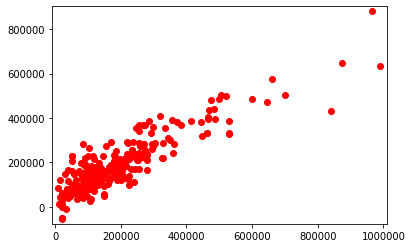

In [23]:
plot_test_predict(X_test, y_predict, y_test)

### Let's try other models!

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

PolyReg = make_pipeline(PolynomialFeatures(3), LinearRegression())
PolyReg.fit(X_train,y_train)
PolyReg.score(X_test,y_test)

-500.2023101035568

### Bayesian Ridge with Polynomial Features

In [25]:
from sklearn.linear_model import BayesianRidge
# bayesian ridge worked well-ish
# Crashes for PolynomialFeatures degree 3 though. Not sure why...
bayesian_ridge = make_pipeline(PolynomialFeatures(2), BayesianRidge())
bayesian_ridge.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('bayesianridge',
                 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                               compute_score=False, copy_X=True,
                               fit_intercept=True, lambda_1=1e-06,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               tol=0.001, verbose=False))],
         verbose=False)

In [26]:
bayesian_ridge.score(X_test, y_test)

0.798198869346998

In [27]:
y_predict = bayesian_ridge.predict(X_test)

model_stats(bayesian_ridge,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.798198869346998
R^2 for Training Set: 0.8560260664627237
RMS error for Test Set: 69060.16482921419
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: 19692.720242769865
y_predict max: 1183043.9696203042
y_predict mean: 183572.21923693927


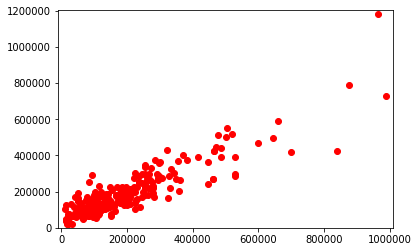

In [28]:
plot_test_predict(X_test, y_predict, y_test)

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
forestreg = RandomForestRegressor(n_estimators=100, max_depth=16).fit(X_train, y_train)

In [30]:
y_predict = forestreg.predict(X_test)

model_stats(forestreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.806099176587096
R^2 for Training Set: 0.9726488527297212
RMS error for Test Set: 67694.85146423566
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: 24565.051490027447
y_predict max: 739690.0
y_predict mean: 182384.0120656682


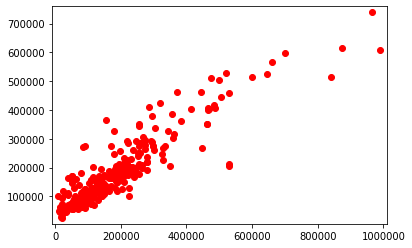

In [31]:
plot_test_predict(X_test, y_predict, y_test)

Even better results than BayesianRidge + polynomial features!

In [32]:
forestreg.feature_importances_

array([1.73033511e-02, 5.65866922e-01, 1.51443235e-02, 1.76618739e-01,
       4.20286001e-03, 2.16653679e-02, 1.63972269e-02, 1.14331180e-02,
       1.01802398e-01, 6.65816354e-03, 7.54322859e-05, 5.64031051e-04,
       1.74724611e-05, 4.93995486e-06, 1.73209876e-04, 7.92712617e-05,
       4.60640611e-04, 8.29203388e-05, 1.98457642e-04, 2.64111022e-04,
       9.40111111e-04, 2.63579949e-05, 2.45712475e-05, 1.94170315e-04,
       6.07016379e-04, 1.19877635e-04, 8.59653696e-06, 2.81547119e-05,
       4.33244203e-04, 1.25002858e-04, 3.77755307e-05, 3.90897780e-05,
       4.81902808e-05, 5.66565233e-05, 5.49894755e-05, 1.36058038e-03,
       1.08076059e-06, 5.19484896e-05, 1.13423060e-04, 4.16577255e-05,
       2.45156392e-04, 2.74398279e-04, 6.23824241e-05, 1.53276682e-04,
       2.29913140e-03, 1.81158463e-06, 1.00225485e-06, 6.11121243e-04,
       8.83137120e-06, 4.63951565e-05, 1.33701493e-04, 4.75920210e-05,
       1.55224219e-05, 8.43777542e-06, 7.38996957e-05, 1.16402046e-04,
      

In [33]:
pd.Series(forestreg.feature_importances_, index=X_test.columns)

land_size                             1.730335e-02
land_value                            5.658669e-01
year_built                            1.514432e-02
sqft_sum                              1.766187e-01
bed_sum                               4.202860e-03
bath_sum                              2.166537e-02
days_ago                              1.639723e-02
main_bldg_year                        1.143312e-02
main_bldg_effective_year              1.018024e-01
room_sum                              6.658164e-03
Sub-AURORA ADDITION                   7.543229e-05
Sub-BAUMANS ADDITION                  5.640311e-04
Sub-BELL VERN ADDITION                1.747246e-05
Sub-CARLE & COLCORD ADDITION          4.939955e-06
Sub-CASHION PLACE ADDITION            1.732099e-04
Sub-CASHION PLACE AMD                 7.927126e-05
Sub-CENTRAL PARK ADDITION             4.606406e-04
Sub-CLASSENS CREAM RIDGE              8.292034e-05
Sub-COLLEGE ADDITION                  1.984576e-04
Sub-CRESTWOOD ADDITION         

We notice that land value is very high in feature_importances_. If we remove land value, sure enough, the R^2 and RMS error are worse than polynomial Bayesian or even linear regression (with land value removed). Looks like it might be overfitting, as decision tree/random forest can have a tendency to do...

In [34]:
# RandomForest, no land value

X_train_no_lv = X_train.drop('land_value',axis=1)
X_test_no_lv = X_test.drop('land_value',axis=1)

forestreg_no_lv = RandomForestRegressor(n_estimators=50, max_depth=12).fit(X_train_no_lv, y_train)
y_predict_no_lv = forestreg_no_lv.predict(X_test_no_lv)
model_stats(forestreg_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.6935606512799894
R^2 for Training Set: 0.9483524490198552
RMS error for Test Set: 85101.66916181076
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: 30532.403552657408
y_predict max: 627018.9743589744
y_predict mean: 182384.0120656682


In [35]:
# BayesianRidge, no land value

bayesian_ridge_no_lv = make_pipeline(PolynomialFeatures(2), BayesianRidge()).fit(X_train_no_lv, y_train)
y_predict_no_lv = bayesian_ridge_no_lv.predict(X_test_no_lv)
model_stats(bayesian_ridge_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.7559146528568086
R^2 for Training Set: 0.834988815729373
RMS error for Test Set: 75951.55456452204
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -23695.612901362125
y_predict max: 1191053.8654405153
y_predict mean: 182384.0120656682


But we see that BayesianRidge can return negative values too! Let's play with parameters anyway with GridSearchCV...

In [36]:
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,20),
        'n_estimators': (10,50,100,500),
    },
    cv=5, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X_train, y_train)

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:
grid_result.best_params_

{'max_depth': 13, 'n_estimators': 500}

### MinMaxScaler + Ridge + PolynomialFeatures

In [38]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler


mm_scaler = MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X_train)
X_test_minmax = mm_scaler.transform(X_test)


mms_ridge = make_pipeline(PolynomialFeatures(2), Ridge(alpha=2))
mms_ridge.fit(X_train_minmax, y_train)


mms_ridge.score(X_test_minmax, y_test)


0.7777467307748255

In [39]:
y_predict = mms_ridge.predict(X_test_minmax)

model_stats(mms_ridge,X_test_minmax,y_test,X_train_minmax,y_train,y_predict)

R^2 for Test Set: 0.7777467307748255
R^2 for Training Set: 0.9245631411767878
RMS error for Test Set: 72475.27834175766
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -49058.65029145697
y_predict max: 918120.819452001
y_predict mean: 183278.11770444468


In [40]:
mm_scaler.inverse_transform(X_train_minmax)

array([[4.7916e+03, 2.4353e+04, 1.9120e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.4052e+03, 2.8852e+04, 1.9850e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [9.5832e+03, 2.0722e+04, 1.9580e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [4.7916e+03, 2.4353e+04, 1.9120e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0984e+03, 4.7645e+04, 1.9350e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.9696e+03, 2.8840e+04, 1.9240e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [41]:
X_train

,land_size,land_value,year_built,sqft_sum,bed_sum,bath_sum,days_ago,main_bldg_year,main_bldg_effective_year,room_sum,Sub-AURORA ADDITION,Sub-BAUMANS ADDITION,Sub-BELL VERN ADDITION,Sub-CARLE & COLCORD ADDITION,Sub-CASHION PLACE ADDITION,Sub-CASHION PLACE AMD,Sub-CENTRAL PARK ADDITION,Sub-CLASSENS CREAM RIDGE,Sub-COLLEGE ADDITION,Sub-CRESTWOOD ADDITION,Sub-CROWN HEIGHTS ADD,Sub-DARRALLS SECOND ADD,Sub-DENNISTON PARK ADD,Sub-DOUGLAS PLACE ADD,Sub-EDGEMERE PARK ADD,Sub-EDGEMERE TERRACE,Sub-EPWORTH VIEW ADD,Sub-GARDEN ADDITION,Sub-GATEWOOD ADDITION,Sub-GRAND VIEW ADDITION,...,Descr-Duplex One half Story,Descr-Duplex Two Story,Descr-Permit Value,Descr-Ranch 1 Story,Descr-Salvage,Descr-Split Level,Descr-Townhouse Multiple Story,Descr-Triplex Multiple Story,Exterior-,Exterior-Frame Aluminum,Exterior-Frame Asbestos,Exterior-Frame Brick Veneer,Exterior-Frame Hardboard,Exterior-Frame Masonry Veneer,Exterior-Frame Permastone,Exterior-Frame Siding,Exterior-Frame Stucco,Exterior-Frame Vinyl,Exterior-High Profile Dome,Exterior-Masonry Concrete Block,Exterior-Masonry Stone,Exterior-Minimal,Exterior-None,Roof-Flat,Roof-Gable,Roof-Gable/Hip,Roof-Gambrel,Roof-Hip,Roof-Hip/Gable,Roof-Mansard
836,4791.6,24353,1912.0,1899.0,4.0,2.50,307,1912.0,2019.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
200,7405.2,28852,1985.0,1264.0,2.0,2.00,195,1985.0,2019.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
351,9583.2,20722,1958.0,1468.0,2.0,1.50,126,1958.0,1958.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65,8276.4,80171,1936.0,1120.0,2.0,1.00,97,1936.0,2002.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
881,5227.2,16881,1917.0,1202.0,2.0,2.00,135,1917.0,2016.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
773,5662.8,16912,1912.0,1100.0,3.0,1.00,252,1912.0,1912.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
272,6098.4,15498,1950.0,810.0,2.0,1.00,251,1950.0,1994.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
986,6969.6,26040,1928.0,1170.0,2.0,1.00,275,1928.0,1980.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
165,9147.6,35998,1945.0,1426.0,2.0,1.50,57,1945.0,2009.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
683,6098.4,15007,1946.0,1187.0,3.0,1.00,212,1946.0,1968.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Like with linear regression, we again have the issue that some output values turn out to be negative.

### Lasso

In [42]:
from sklearn.linear_model import Lasso

lassoreg = Lasso(positive=True,fit_intercept=True,alpha=2).fit(X_train, y_train)
lassoreg.score(X_test,y_test)

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1388838924519.938, tolerance: 1675990495.5100203
  positive)


0.7803202499118823

In [43]:
y_predict = lassoreg.predict(X_test)
model_stats(lassoreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7803202499118823
R^2 for Training Set: 0.8255083784331092
RMS error for Test Set: 72054.4530506848
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -61305.54311924707
y_predict max: 873158.5254674768
y_predict mean: 184802.87954554328


### Preliminary Conclusion

So far, the BayesianRidge regressor appears to be the a good choice. However in some instances it may be prone to returning negative values, which is not acceptable. It may be possible to tweak the parameters to return positive price, or possibly to add an additional step to the pipeline to handle cases of negative value. The effectiveness of these approaches hasn't been evaluated as of yet.

RandomForestRegressor also seems to be a good choice. In some cases it may perform worse than BayesianRidge, but has not exhibited any issues with returning negative values as other regressors have.

### Adding latitude/longitude

Let's import property_centroids.csv, which contains a point (latitude/longitude) to represent each parcel in Oklahoma County.

This was generated by using the esri2geojson tool, part of the esridump pip package, to obtain GIS data from the Oklahoma County Assessor ESRI API (https://oklahomacounty.geocortex.com/arcgis/rest/services/ParcelData/OklahomaCountyAllParcelsData1/MapServer/7/). This contains polygons representing the boundaries of each parcel, in addition to a bunch of other (mostly redundant) data.

The data was loaded into a geopandas GeoDataFrame, and we calculated the centroid of each parcel as to have one point (latitude/longitude) representing each parcel. This data and the account numbers were exported to a CSV file which we will now load.

In [44]:
centroids = pd.read_csv('property_centroids.csv')

In [45]:
centroids

,accountno,lon,lat
0,R264163000,-97.203294,35.685093
1,R168644650,-97.185985,35.648851
2,R168644325,-97.238711,35.642071
3,R168644975,-97.154664,35.641265
4,R168642725,-97.225475,35.670637
5,R168644950,-97.145754,35.641221
6,R168642475,-97.181177,35.684972
7,R168643825,-97.181304,35.655883
8,R168644050,-97.216728,35.656053
9,R168641575,-97.189891,35.713954


In [46]:
merged_df = pd.merge(merged_df, centroids, left_on='account_number', right_on='accountno', how='inner')
included_fields = included_fields + ['lat','lon']
new_df = (merged_df[included_fields][merged_df.price != 0]
          .dropna()
          .reset_index()
          .drop(columns=['index']))

In [47]:
new_df

,land_size,land_value,subdivision,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_hvac,main_bldg_description,main_bldg_exterior,main_bldg_quality,main_bldg_roof,main_bldg_year,main_bldg_effective_year,room_sum,lat,lon
0,9147.6,48230,DOUGLAS PLACE ADD,68.0,1951.0,1352.0,3.0,1.50,108000,135,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Gable,1951.0,1997.0,6.0,35.522050,-97.521208
1,9147.6,48230,DOUGLAS PLACE ADD,68.0,1951.0,1352.0,3.0,1.50,108000,188,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Gable,1951.0,1997.0,6.0,35.522050,-97.521208
2,9147.6,45900,EDGEMERE TERRACE,68.0,1951.0,2018.0,3.0,2.00,305000,223,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1951.0,2007.0,7.0,35.515214,-97.519994
3,6969.6,37100,DOUGLAS PLACE ADD,69.0,1950.0,1429.0,2.0,1.75,157000,183,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Gable,1950.0,1970.0,6.0,35.521623,-97.522902
4,8276.4,42840,EDGEMERE TERRACE,68.0,1951.0,2155.0,3.0,2.00,335000,69,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1951.0,2007.0,4.0,35.515678,-97.519815
5,8276.4,42840,EDGEMERE TERRACE,67.0,1952.0,2097.0,3.0,2.50,343500,162,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1952.0,2010.0,7.0,35.515679,-97.519345
6,8276.4,42840,EDGEMERE TERRACE,67.0,1952.0,2097.0,3.0,2.50,343500,192,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1952.0,2010.0,7.0,35.515679,-97.519345
7,17859.6,85603,Other,67.0,1952.0,2541.0,4.0,2.00,415000,169,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Average,Hip,1952.0,2019.0,8.0,35.514866,-97.518660
8,7405.2,36720,EDGEMERE TERRACE,68.0,1951.0,1416.0,3.0,1.75,182500,245,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1951.0,2015.0,5.0,35.516010,-97.519365
9,8276.4,80559,CROWN HEIGHTS ADD,83.0,1936.0,2316.0,4.0,1.75,555000,154,Central Air to Air,1½ Story Fin,Frame Masonry Veneer,Average,Gable,1936.0,2017.0,9.0,35.514304,-97.525810


Now we have the features we had before, along with the latitude and longitude! Now let's convert the categorical features to one hot encoding and see how it performs.

In [48]:
encoded_dfs = []
encoders = {}
for (col_name, prefix) in encoded_df_names:
    cur_df = return_encoded(new_df, col_name, prefix)
    encoded_dfs.append(cur_df)
    
new_df = new_df.drop(columns=([x[0] for x in encoded_df_names]+[x for x in unused_col_names]))
new_df = pd.concat(([new_df] + [x for x in encoded_dfs]), axis=1)

X = new_df.drop('price',axis=1)
y = new_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Bayesian Ridge w/latlon

In [49]:
from sklearn.linear_model import BayesianRidge
# bayesian ridge worked well-ish
# Crashes for PolynomialFeatures degree 3 though. Not sure why...
bayesian_ridge = make_pipeline(PolynomialFeatures(2), BayesianRidge())
bayesian_ridge.fit(X_train, y_train)

bayesian_ridge.score(X_test, y_test)

y_predict = bayesian_ridge.predict(X_test)

model_stats(bayesian_ridge,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7871387287600194
R^2 for Training Set: 0.8477921080826825
RMS error for Test Set: 67523.46686465529
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: 8385.659518788074
y_predict max: 1108477.180686517
y_predict mean: 189373.30034492954


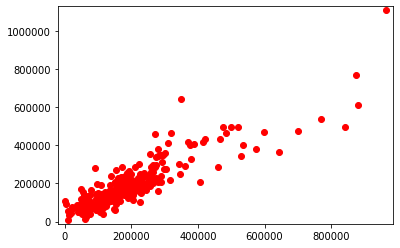

In [50]:
plot_test_predict(X_test, y_predict, y_test)

### Random Forest w/latlon

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
forestreg = RandomForestRegressor(n_estimators=100, max_depth=16).fit(X_train, y_train)

y_predict = forestreg.predict(X_test)

model_stats(forestreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7960250991184028
R^2 for Training Set: 0.9737457483368921
RMS error for Test Set: 66098.98214417702
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: 19140.0
y_predict max: 798535.0
y_predict mean: 187578.04495315038


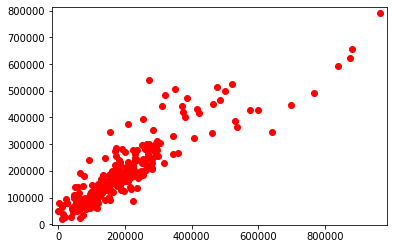

In [52]:
plot_test_predict(X_test, y_predict, y_test)

In both cases, it looks like the R^2 is slightly worse but the RMS error is better than with no lat/lon.

Not totally bad! Let's see what it looks like if we take out the land value like we'd tried before...

### Latlon, no land value

In [59]:
# RandomForest, no land value, with latlon

X_train_no_lv = X_train.drop('land_value',axis=1)
X_test_no_lv = X_test.drop('land_value',axis=1)

forestreg_no_lv = RandomForestRegressor(n_estimators=100, max_depth=12).fit(X_train_no_lv, y_train)
y_predict_no_lv = forestreg_no_lv.predict(X_test_no_lv)
model_stats(forestreg_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.8072355692313926
R^2 for Training Set: 0.9664344803419364
RMS error for Test Set: 64256.912853816655
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: 18785.056530214424
y_predict max: 746640.0
y_predict mean: 187578.04495315038


So when we remove the land value but keep the latlon, **the RandomForestRegressor actually does slightly BETTER than in any other case.**

If we can make a good prediction without using the land value (or anything else with a monetary value) as part of X, that would be nice. But if we can make better predictions, that's really awesome!

Let's see what the results from GridSearchCV look like.

In [54]:
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,20),
        'n_estimators': (10,50,100,500),
    },
    cv=5, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X_train, y_train)

grid_result.best_params_

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 12, 'n_estimators': 100}

Let's try BayesianRidge now.

In [55]:
# BayesianRidge, no land value, with latlon

bayesian_ridge_no_lv = make_pipeline(PolynomialFeatures(2), BayesianRidge()).fit(X_train_no_lv, y_train)
y_predict_no_lv = bayesian_ridge_no_lv.predict(X_test_no_lv)
model_stats(bayesian_ridge_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.7123177403592788
R^2 for Training Set: 0.8399166831447933
RMS error for Test Set: 78498.78722449373
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: -15596.4606237337
y_predict max: 930141.6268175021
y_predict mean: 187807.75445534362


BayesianRidge doesn't do so well in this case. From what it looks like, the RandomForestRegressor with latlon and with no land value is the way to go!